# Notebook II - Cleaning & Processing `weather_data.csv`
---

In [38]:
# imports
import pandas as pd
import numpy as np

# graphing
import matplotlib.pyplot as plt
import seaborn as sns

---
## 2. Cleaning Weather Data

In [49]:
# read weather data
weather = pd.read_csv("./data/weather_data.csv")

weather.head()

,Date,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Events
0,1/1/14,69,54,39,83,68,52,10,10,8,13,4,22,0,NaN
1,1/2/14,55,44,33,83,55,26,10,10,9,21,8,31,0,NaN
2,1/3/14,58,43,28,75,49,22,10,10,10,14,4,21,0,NaN
3,1/4/14,71,57,42,89,68,47,10,10,8,16,7,28,0,NaN
4,1/5/14,59,47,34,87,59,31,10,10,4,21,10,34,0,NaN


The data here is time-series (we are tracking different metrics of weather over time). There is 3 years of weather data, from 2014-2016. 2016 was a leap year, so we should expect 1096 rows.

In [50]:
print(f"Rows:   {weather.shape[0]}")
print(f"Columns:   {weather.shape[1]}")

Rows:   1096
Columns:   15


In [51]:
# brief check to see there are 1096 unique dates
len(weather['Date'].unique())

1096

In [52]:
# missing values and data types
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Date                  1096 non-null   object
 1   TempHigh_F            1096 non-null   int64 
 2   TempAvg_F             1096 non-null   int64 
 3   TempLow_F             1096 non-null   int64 
 4   HumidityHigh_Percent  1096 non-null   object
 5   HumidityAvg_Percent   1096 non-null   object
 6   HumidityLow_Percent   1096 non-null   object
 7   VisibilityHigh_Miles  1096 non-null   object
 8   VisibilityAvg_Miles   1096 non-null   object
 9   VisibilityLow_Miles   1096 non-null   object
 10  WindHigh_MPH          1096 non-null   object
 11  WindAvg_MPH           1096 non-null   object
 12  WindGust_MPH          1096 non-null   object
 13  Precipitation_Inches  1096 non-null   object
 14  Events                352 non-null    object
dtypes: int64(3), object(12)
memory usage: 

There are missing values for just one column, "Events". Additionally, we have a majority of the numeric columns listed as 'object'. Let's fix these issues first.

---
### 2a. Investigating the "Events" Column

In [53]:
weather['Events'].unique()

array([nan, 'Rain', 'Fog', 'Rain,Snow', 'Rain,Thunderstorm', 'Fog,Rain',
       'Thunderstorm', 'Fog,Rain,Thunderstorm', 'Fog,Thunderstorm'],
      dtype=object)

Looks like the missing values here are representing the absence of any specific weather event on a given day. There are also some days where ***multiple*** weather events occurred. We can dummify the values in this column into separate variables representing the occurrence of that event.

In [54]:
# first replace NaNs w/ empty strings
weather['Events'].fillna('', inplace = True)

In [55]:
# now, split 'Events' column into separate dummies via pd.get_dummies()
weather_dummies = pd.get_dummies(weather['Events'].str.split(',', expand = True).stack(), prefix = '', prefix_sep = ''
                                 , drop_first = True) # make sure to set "drop_first" = True! --> this will drop the default dummy

# concat dummy cols w/ weather df
weather = pd.concat([weather, weather_dummies.groupby(level = 0).sum()], axis = 1)

In [56]:
# preview a window of the last few columns we just created
weather.loc[:,'Events':].sample(5)

,Events,Fog,Rain,Snow,Thunderstorm
738,,0,0,0,0
502,Rain,0,1,0,0
795,,0,0,0,0
560,,0,0,0,0
987,Rain,0,1,0,0


The binary representations of the unique events (fog, rain, snow, thunderstorm, and "no events") look accurate here. I also dropped the default variable that represents the lack of the other events. Keeping this would create issues with correlations among the dummy variables. <br> Now, we can drop the 'Events' column.

In [57]:
# drop 'Events'
weather.drop(columns = ['Events'], inplace = True)

---
### 2b. Fixing Columns

In [60]:
# convert 'date' to datetime
weather['Date'] = pd.to_datetime(weather['Date'], format = '%m/%d/%y')

Weather data and metrics are generally continuous. So, it makes most sense to convert numeric values to float types.

In [61]:
# quickly converting Temp vars to float
weather[['TempHigh_F', 'TempAvg_F', 'TempLow_F']] = weather[['TempHigh_F', 'TempAvg_F', 'TempLow_F']].astype(float)

In [62]:
# everything aside from 'Date' should be float (weather data is continuous so float) since they are numeric values
weather.dtypes

Date                    datetime64[ns]
TempHigh_F                     float64
TempAvg_F                      float64
TempLow_F                      float64
HumidityHigh_Percent            object
HumidityAvg_Percent             object
HumidityLow_Percent             object
VisibilityHigh_Miles            object
VisibilityAvg_Miles             object
VisibilityLow_Miles             object
WindHigh_MPH                    object
WindAvg_MPH                     object
WindGust_MPH                    object
Precipitation_Inches            object
Fog                              int64
Rain                             int64
Snow                             int64
Thunderstorm                     int64
dtype: object

It looks like there are several numeric columns that are being read as 'object.' It's possible that some of these values are actually missing, but are instead denoted with something other than "NaN". Let's quickly search through the ones reading as 'object' to check.

In [63]:
# print to console the unique values for the 'objects' EXCEPT for date (date is OK)

# place holder for columns we need to fix
broken_cols = []

for var in weather.columns[1::]: #slice to remove date
    if weather[var].dtype == 'O':
        print(var,weather[var].unique())
        print("="*50)
        broken_cols.append(var) #store these columns

HumidityHigh_Percent ['83' '75' '89' '87' '50' '68' '93' '84' '70' '49' '55' '45' '59' '64'
 '71' '78' '81' '85' '76' '66' '69' '63' '80' '86' '79' '82' '58' '96'
 '90' '67' '73' '92' '56' '53' '100' '72' '97' '60' '77' '42' '51' '44'
 '37' '94' '91' '95' '-' '88' '74' '62' '61' '65' '57' '54' '52' '48']
HumidityAvg_Percent ['68' '55' '49' '59' '38' '43' '75' '80' '81' '53' '51' '41' '35' '31'
 '45' '39' '44' '64' '60' '52' '48' '42' '71' '69' '74' '54' '63' '70'
 '57' '58' '65' '85' '56' '79' '72' '76' '62' '88' '66' '36' '61' '78'
 '77' '73' '32' '33' '27' '87' '40' '67' '83' '86' '-' '50' '92' '46' '97'
 '91' '90' '47' '94' '82' '89' '95' '37' '84' '93' '28']
HumidityLow_Percent ['52' '26' '22' '47' '31' '17' '57' '66' '68' '13' '14' '12' '21' '20'
 '19' '50' '39' '27' '48' '42' '60' '59' '65' '46' '49' '58' '40' '44'
 '70' '38' '30' '15' '32' '29' '77' '43' '37' '54' '69' '34' '83' '55'
 '53' '16' '18' '24' '45' '51' '28' '36' '67' '35' '72' '10' '11' '41'
 '79' '61' '73' '56' '-' 

As expected, there are missing values denoted as '-' for the 'object' columns. I will fix these columns and investigate the "missingness" of the data. That is to say, I will check the null count and if it is substantially high, we can drop the column altogther. If the null count is low, we can keep the column and interpolate the missing values. <br><br>
For 'Precipitation_Inches', a quick Google search showed me that 'T' in precipitation data actually denotes to "trace" amounts of precipitation. Since this typically represents less than 0.005 inches of water, I will round this to 0.

In [64]:
# replace '-' with NaN
weather[broken_cols] = weather[broken_cols].replace('-', np.nan)

In [65]:
# change precipitation 'T' to 0.0
weather['Precipitation_Inches'].replace('T', 0.0, inplace = True)

In [66]:
# converting the columns to numeric
weather[broken_cols] = weather[broken_cols].astype('float')

In [67]:
# count the null values for the columns that had '-'
weather.isna().sum().sort_values(ascending = False)

VisibilityLow_Miles     12
VisibilityHigh_Miles    12
VisibilityAvg_Miles     12
WindGust_MPH             3
HumidityHigh_Percent     2
HumidityAvg_Percent      2
HumidityLow_Percent      2
WindHigh_MPH             2
WindAvg_MPH              2
Precipitation_Inches     0
Snow                     0
Rain                     0
Fog                      0
Date                     0
TempHigh_F               0
TempLow_F                0
TempAvg_F                0
Thunderstorm             0
dtype: int64

Not many values are missing here. Interpolating is the best bet here to fill the values since dropping by rows would mean we are losing an entire day's worth of data. <br><br>
***SIDE NOTE:*** *It may be problematic to keep all metrics of a specific measure of weather. 'Low', 'Avg', and 'High' of the same metric (visiblity, humidity) will likely create multicollinearity once we get to modeling. But, I will display this via a correlation coefficient matrix later prior to dropping.*

---
#### Interpolating Missing Weather Data

I will use simple linear interpolation to fill the few missing values in the dataset. I believe linear interpolation is a sound technique here since weather from day to day will not drastically differ.

In [68]:
# quick graph to visually see missing value

# start index on date for missing
index = weather[weather['HumidityAvg_Percent'].isna()]['Date'].index[0]

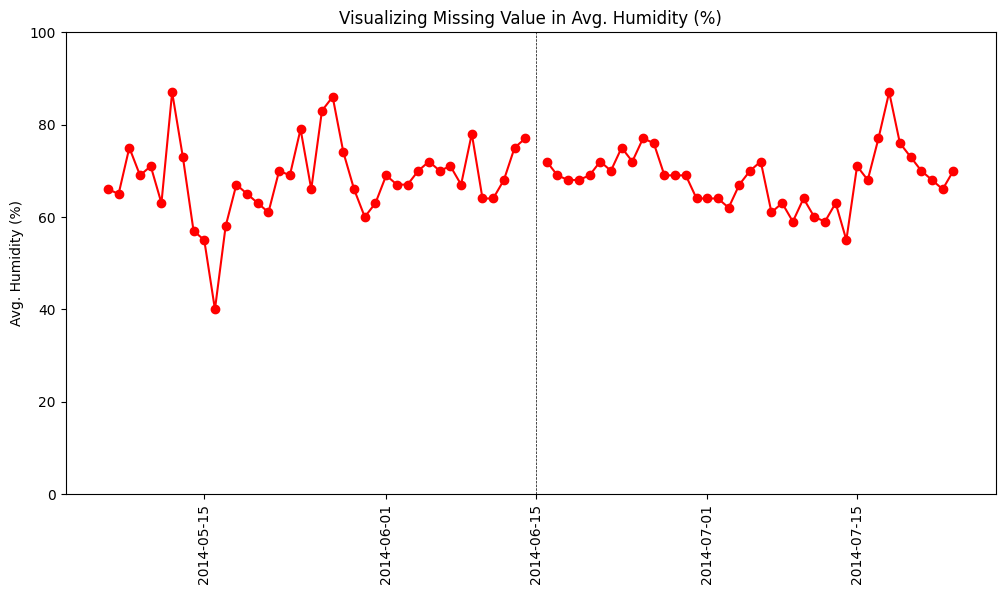

In [69]:
# creating a sample visual where data is missing in a time-series
plt.figure(figsize = (12, 6))
plt.plot(weather.iloc[index-40:index+40]['Date'], weather.iloc[index-40:index+40]['HumidityAvg_Percent'], color = 'red', marker = 'o')
plt.axvline(x = weather['Date'][index], color = 'black', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation = 90)
plt.ylim(0, 100)
plt.ylabel('Avg. Humidity (%)')
plt.title('Visualizing Missing Value in Avg. Humidity (%)');

plt.savefig('./graphs/missing_value_graph.jpeg', dpi = 1080)

I wanted to visually represent the missing value in this time-series. There aren't many major swings from day-to-day. We will assume this for now for the other weather metrics missing data. So, we can use linear interpolation to fill in missing values. The values will essentially be averages (or slope) between the 2 closest available points. 

In [70]:
# interpolate columns (exclude 'Date')
interpolate_cols = list(weather.columns[1::])

weather[interpolate_cols] = weather[interpolate_cols].interpolate(method = 'linear', axis = 0)

In [71]:
# quick check if done correctly using previous missing index on avg_humidity
weather['HumidityAvg_Percent'].iloc[index-1:index+2] 

# confirmed!

164    77.0
165    74.5
166    72.0
Name: HumidityAvg_Percent, dtype: float64

In [72]:
# no more missing values
weather.isna().sum() 

Date                    0
TempHigh_F              0
TempAvg_F               0
TempLow_F               0
HumidityHigh_Percent    0
HumidityAvg_Percent     0
HumidityLow_Percent     0
VisibilityHigh_Miles    0
VisibilityAvg_Miles     0
VisibilityLow_Miles     0
WindHigh_MPH            0
WindAvg_MPH             0
WindGust_MPH            0
Precipitation_Inches    0
Fog                     0
Rain                    0
Snow                    0
Thunderstorm            0
dtype: int64

--- 
<br>

***SIDE NOTE:*** One additional concern I had while doing last checks on the weather data was regarding instances of having records of 0 inches of precipitation, but having presence of rain, snow, or thunderstorm. In some cases, rain or snow could have been logged in trace amounts (effectively rounding to 0 inches). However, in some cases, there are thunderstorms present and precipitation records are still 0. I would love to discuss how to question and research the validity of data in these instances. Here is an example below:

<br>

In [73]:
weather[(weather['Precipitation_Inches'] == 0) & (weather['Thunderstorm']) == 1].loc[:,'Precipitation_Inches':].head()

,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm
86,0.0,0,0,0,1
128,0.0,0,1,0,1
144,0.0,0,0,0,1
184,0.0,0,0,0,1
230,0.0,0,0,0,1


How should we test the accuracy of this data in the future? It is totally possible that the thunderstorms were brief, resulting in "Trace" amounts of precipitation. However, I still think it would be useful to test the validity of some of the records. For now, I will leave the data as is to avoid creating gaps in the time-series.

The weather data is now ready to be saved and merged with the trips dataset. I will investigate which variables to exlude for the model in the next step after performing some brief EDA.

In [74]:
# save cleaned weather data
weather.columns = weather.columns.str.lower()     # lowercase column names

weather.to_csv('./cleaned_data/weather_cleaned.csv', index = False)